#__ANM-NCPOP__
Define a function for solving the NCPO problems with given standard deviations of process noise and observtion noise, length of  estimation data and required relaxation level.

* Generate the artificial data or standardized observational data.
* Learn the Causal Structure beneath the observation data.
* Visualize the comparison of estimated/true graphs using a heat map.
* Calculate Metrics.
* Demonstrate the performance of method ANM-NCPOP in a heatmap.

**Flow**

Class NCPOLR: Functions generate_operators, estimate

Class ANM_NCPO: Functions learn, ANMNCPO_fitness

                                                      [Input raw data]
                                                              ↓
                                                    <generate_operators>
                                                              |
                                                              | Generate Operators
                                                              ↓
                                                  <estimate or estimate2>
                                                              |
                                                              | Solve NCPOLR problem
                                                              ↓
                        [Output DAG] <--- <learn> <--- <ANMNCPO_fitness>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/")
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data"
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content/drive/MyDrive/Colab Notebooks/NCPOP/"

In [3]:
### for colab ###
# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
# Install MOSEK and ncpol2sdpa if not already installed
!pip install mosek torch
!pip install ncpol2sdpa
# !pip install networkx
!pip install gcastle==1.0.3rc2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 19.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

In [48]:
import os
import re
import csv
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
from ncpol2sdpa import*



class Anm_ncpop_test(object):
    '''
    A class for simulating (causal) DAG, where the true DAG is a weighed/binary adjacency matrix based on ground truth.

    Parameters
    ------------------------------------------------------------------------------------------------
    File_PATH: str
            Read file path
    File_NAME: str
            Read data name
    File_PATH_Summary_Datails: str
            Save file path
    datasize: series

    Timesize: series

    Returns
    ------------------------------------------------------------------------------------------------
    Metrics DAG: np.matrix
            heatmap between estimate DAG matrix and true DAG
    Casaul Metrics: np.matrix
            estimate DAG matrix
    Summary scores table: pd.dataframe
           col_names = ['Datasize','Timesets', 'Duration', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    Summary table: pd.dataframe
           col_names = ['DataSize', 'Timesets', 'F1_Score', 'Duration']

    Examples
    -------------------------------------------------------------------------------------------------
    >>> # filename = LinearSEM_GaussNoise
    >>> # data_name = LinearSEM_GaussNoise_6Nodes_15Edges_TS
    >>> # save_name = LinearSEM_GaussNoise_6Nodes_15Edges_TS_15Datasize_5Timesets

    >>> datasize = range(5, 40, 5)
    >>> Timesize = range(3, 6, 1)
    >>> File_PATH_Base = 'Test/Examples/Test_data/'
    >>> File_PATH_Summary_Datails = 'Test/Examples/Test_data/Summary'
    >>> File_PATH = File_PATH
    >>> Data_NAME = 'LinearSEM_GaussNoise_6Nodes_15Edges_TS.npz'
    >>> # Data_NAME = 'Krebs_Cycle_16Nodes_43Edges_TS.npz'
    >>> rt = Anm_ncpop_test(File_PATH_Base, Data_NAME, File_PATH_Summary_Datails, datasize, Timesize)
    >>> rt.Ancpop()

    '''
    def __init__(self, File_PATH = None, Datasize=range(5, 40, 5), Timeset= range(3, 6, 1)):
        self.File_PATH = File_PATH
        self.Datasize =  Datasize
        # self.Datasize_num = len(self.Datasize)
        self.Timeset = Timeset
        # self.Timesize_num = len(self.Timesize)
        self.filename = filename
        # re.split("_", re.split("/", self.File_PATH_Datasets)[-1])[0]


    def Ancpop(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Base):
            os.makedirs(self.File_PATH_Base)
        print('ANM-NCPOP INFO: Created Basement'+ ' File!')

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Summary = self.File_PATH_Base + 'Summary_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Summary):
            os.makedirs(self.File_PATH_Summary)
        print('ANM-NCPOP INFO: Created Summary'+ ' File!')

        self.File_PATH_Datasets = self.File_PATH_Base + 'Datasets_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Datasets):
            os.makedirs(self.File_PATH_Datasets)
            if data_type == 'Real':
                dt = Real_Data_Standardization(self.File_PATH, self.filename)
                dt.standardize_data()
            elif data_type == 'Real':

            else:

        print('ANM-NCPOP INFO: Created Datasets' + ' File!')

        ################################################  Create Second Tier Folders #############################################
        self.File_PATH_Summary_Datails = self.File_PATH_Summary + 'Summary_Datails_'+self.filename +'/'
        self.File_PATH_MetricsDAG = self.File_PATH_Summary +'MetricsDAG_'+self.filename +'/'
        if not os.path.exists(self.File_PATH_Summary_Datails):
            os.makedirs(self.File_PATH_Summary_Datails)
        print('ANM-NCPOP INFO: Created Summary_Datails'+ ' File!')
        if not os.path.exists(self.File_PATH_MetricsDAG):
            os.makedirs(self.File_PATH_MetricsDAG)
        print('ANM-NCPOP INFO: Created MetricsDAG'+ ' File!')

        ################################################  Analyzing Data under Datasets ###############################
        tqdm=os.listdir(self.File_PATH_Summary_Datails)
        read_Dir=os.listdir(self.File_PATH_Datasets)
        while len(tqdm)!= len(read_Dir):
            for data_name in read_Dir:
                # print(file_f)
                filename = utils.saveName_transfer_to_filename(data_name)

                df_F1 = self.File_PATH_Summary_Datails + 'F1_'+ data_name +'.csv'
                if not os.path.exists(df_F1):
                    Rawdata = np.load(self.File_PATH_Datasets+data_name)
                    self.Ancpop_estimate(self, Rawdata, data_name)
                print('ANM-NCPOP INFO: Finished '+ data_name+'Analyzing!')
        print('ANM NCPOP INFO: Finished simulations!')

    @staticmethod
    def Ancpop_estimate(self, Rawdata, data_name):
        Raw_data = Rawdata['x']
        true_dag = Rawdata['y']
        duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['Datasize','Timesets', 'Duration', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
        for i in self.Datasize:
            for j in self.Timeset:
                data = Raw_data[:, :i, :j]
                t_start = time.time()
                # Test ANM-NCPOP
                anmNCPO = ANM_NCPO(alpha=0.05)
                anmNCPO.learn(data = data)
                # Save estimate causal_matrix
                save_name = data_name+'_' + str(i) + 'Datasize_'+str(j) +'Timesets'
                pd.DataFrame(anmNCPO.causal_matrix).to_csv(self.File_PATH_MetricsDAG + save_name+'.csv',index=False)

                # Plot predict_dag and true_dag
                GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG + save_name+'.png')

                # Save met.metrics
                met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
                dict1 = {'Datasize':i, 'Timesets':j, 'Duration':time.time()-t_start}
                dict2 = met.metrics
                dict = {**dict1, **dict2}
                df = pd.concat([df, pd.DataFrame([dict])])
                if math.isnan(float(met.metrics['F1'])):
                    f1_anm_ncpop.append(0.2)
                else:
                    f1_anm_ncpop.append(met.metrics['F1'])
                print('ANM-NCPOP INFO: ' + save_name +' is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
                print('ANM-NCPOP INFO: Time Duration is '+ str(time.time()-t_start))
                duration_anm_ncpop.append(time.time()-t_start)
        df.to_csv(self.File_PATH_MetricsDAG + 'Scores_'+data_name+'.csv', index=False)
        df_F1 = pd.DataFrame({"DataSize":self.Datasize, "Timesets":self.Timesets, 'F1_Score':f1_anm_ncpop, 'Duration':duration_anm_ncpop})
        df_F1.to_csv(self.File_PATH_Summary_Datails + 'F1_'+data_name+'.csv',index=False)
        return df_F1

class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()


    def generate_operators(name, n_vars=1, hermitian=None, commutative=False):
        """Generates a number of commutative or noncommutative operators

        :param name: The prefix in the symbolic representation of the noncommuting
                    variables. This will be suffixed by a number from 0 to
                    n_vars-1 if n_vars > 1.
        :type name: str.
        :param n_vars: The number of variables.
        :type n_vars: int.
        :param hermitian: Optional parameter to request Hermitian variables .
        :type hermitian: bool.
        :param commutative: Optional parameter to request commutative variables.
                            Commutative variables are Hermitian by default.
        :type commutative: bool.

        :returns: list of :class:`sympy.physics.quantum.operator.Operator` or
                  :class:`sympy.physics.quantum.operator.HermitianOperator`
                  variables

        :Example:

        >>> generate_variables('y', 2, commutative=True)
        ￼[y0, y1]
        """

        variables = []
        for i in range(n_vars):
            if n_vars > 1:
                var_name = '%s%s' % (name, i)
            else:
                var_name = '%s' % name
            if hermitian is not None and hermitian:
                variables.append(HermitianOperator(var_name))
            else:
                variables.append(Operator(var_name))
            variables[-1].is_commutative = commutative
        return variables

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.00005*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.001*sum(p[i]**2 for i in range(T)) + 0.0005*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise, X[1:]
        else:
            print('Cannot find feasible solution.')
            return


class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape(-1,1)
            yy = y.reshape(-1,1)

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        ncpop_res = regressor.estimate(x, y)
        print(x)
        print(y)

        flag = test_method(np.asarray(ncpop_res[0]).reshape((-1, 1)), np.asarray(ncpop_res[1]).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag




## Test

In [ ]:
datasize = range(5, 40, 5)
Timesize = range(3, 6, 1)
# Krebs_Cycle
File_PATH = "../Test/Datasets/Synthetic datasets/Krebs_Cycle/"
rt = Anm_ncpop_test(File_PATH, datasize, Timesize)
rt.Ancpop()

ANM-NCPOP INFO: Created Basement File!
ANM-NCPOP INFO: Created Summary File!
ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Created Summary_Datails File!
ANM-NCPOP INFO: Created MetricsDAG File!
The problem has 46 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 21/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 8/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 19/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 10/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 9/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 38/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 26/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 22/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 11/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 17/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 14/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 20/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 43/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 16/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 12/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.04            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 28/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 11/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 20/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 3/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 21/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 14/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 39/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 19/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 8/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 9/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 20/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 46 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 36/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 39/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 36/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 19/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 6/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 8/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 39/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 46/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 25/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 40/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 45/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 44/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 5/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 16/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 35/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 40/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 41/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 11/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 16/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 20/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 30/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ANM-NCPOP INFO: Krebs_Cycle_16Nodes_43Edges_TS.npz_5Datasize_3Timesets is done!F1 Score isnan.
ANM-NCPOP INFO: Time Duration is 364.35712575912476
The problem has 61 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1952
Generating moment matrix...
Current number of SDP variables: 10 (done: 0.56%, ETA 00:00:4.5)

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


Reduced number of SDP variables: 1952
Processing 11/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 30/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 21/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 18/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 24/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 13/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 18/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 7/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 30/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 19/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 34/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 16/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 38/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 26/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 8/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 15/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 28/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 29/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 15/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 24/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 5/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 26/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 27/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 13/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 39/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 30/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 41/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 32/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 26/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 24/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.06            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 17/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 6/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 21/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 17/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 12/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 6/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 21/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 19/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 28/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 36/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 4/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 28/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 7/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 22/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 61 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 31/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 23/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 26/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 30/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 7/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 38/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 34/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 13/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 25/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 7/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 34/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Reduced number of SDP variables: 1952
Processing 31/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 27/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 29/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 36/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1952
Processing 4/80 constraints...

Processing 80/80 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1952            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 10153)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1952
Generating moment matrix...
Current number of SDP variables: 266 (done: 13.68%, ETA 00:00:3.5)

# utils

In [33]:
class utils():
    def __init__(self, filename):
        self.filename = filename

    def saveName_transfer_to_filename(filename):
        parts = filename.split('_')
        name_without_extension = parts[:-1]
        parts_to_join = name_without_extension[:-2]

        # join with '_'
        result = '_'.join(parts_to_join)
        return result

    def dataName_transfer_to_filename(filename):
        parts = filename.split('_')
        name_without_extension = parts[:-1]
        parts_to_join = name_without_extension[:-4]

        # join with '_'
        result = '_'.join(parts_to_join)
        return result

    def readable_File(FilePATH):
        read_Dir=os.listdir(FilePATH)
        count = 0
        readable_F = []
        for f in read_Dir:
            file = os.path.join(FilePATH, f)
            if os.path.isdir(file):
                count = count+1
            else:
                readable_F.append(f)
        return count,readable_F

filename = utils.saveName_transfer_to_filename('Krebs_Cycle_16Nodes_43Edges_TS')
print(filename)
filename = utils.dataName_transfer_to_filename('Krebs_Cycle_16Nodes_43Edges_TS_100Datasize_50Timesets')
print(filename)

Krebs_Cycle
Krebs_Cycle


#__Step 1: Get start__


* mount drive
* set envirment
* install packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Results/ThreeDimTS/renyin_TS/")
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/Details_Krebs_Cycle/MetricsDAG/")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data"
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content/drive/MyDrive/Colab Notebooks/NCPOP/"

#__Step 2: NCPOLR__

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
# from inputlds import*
# from functions import*
from ncpol2sdpa import*
from math import sqrt
import numpy as np
from castle.common import GraphDAG
from castle.metrics import MetricsDAG


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()


    def generate_operators(name, n_vars=1, hermitian=None, commutative=False):
        """Generates a number of commutative or noncommutative operators

        :param name: The prefix in the symbolic representation of the noncommuting
                    variables. This will be suffixed by a number from 0 to
                    n_vars-1 if n_vars > 1.
        :type name: str.
        :param n_vars: The number of variables.
        :type n_vars: int.
        :param hermitian: Optional parameter to request Hermitian variables .
        :type hermitian: bool.
        :param commutative: Optional parameter to request commutative variables.
                            Commutative variables are Hermitian by default.
        :type commutative: bool.

        :returns: list of :class:`sympy.physics.quantum.operator.Operator` or
                  :class:`sympy.physics.quantum.operator.HermitianOperator`
                  variables

        :Example:

        >>> generate_variables('y', 2, commutative=True)
        ￼[y0, y1]
        """

        variables = []
        for i in range(n_vars):
            if n_vars > 1:
                var_name = '%s%s' % (name, i)
            else:
                var_name = '%s' % name
            if hermitian is not None and hermitian:
                variables.append(HermitianOperator(var_name))
            else:
                variables.append(Operator(var_name))
            variables[-1].is_commutative = commutative
        return variables

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.00005*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.001*sum(p[i]**2 for i in range(T)) + 0.0005*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise, X[1:]
        else:
            print('Cannot find feasible solution.')
            return


#__Step 3: ANM_NCPO__

In [ ]:
class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape(-1,1)
            yy = y.reshape(-1,1)

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        ncpop_res = regressor.estimate(x, y)
        print(x)
        print(y)

        flag = test_method(np.asarray(ncpop_res[0]).reshape((-1, 1)), np.asarray(ncpop_res[1]).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag



__Test Krebs_Cycle_Data__
* Raw_data.shape = F features, S smples and T timesets Time Series.

* The first number is the number of deep, second number is the number of row and third number is the number of column.

#__Step 4: Test Krebs_Cycle data__


In [ ]:
import time
import sys
import os
import re
import math
import torch
import numpy as np
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

def to_summary(Rawdata, Datasize, Timesets, file_name, true_dag):
    duration_anm_ncpop = []
    f1_anm_ncpop = []
    df = pd.DataFrame(columns=['Datasize','Timesets', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    for i in Datasize:
        for j in Timesets:
            data = Rawdata[:, :i, :j]
            t_start = time.time()
            # Test ANM-NCPOP
            anmNCPO = ANM_NCPO(alpha=0.05)
            anmNCPO.learn(data = data)
            # Save estimate causal_matrix
            pd.DataFrame(anmNCPO.causal_matrix).to_csv(self.File_PATH_MetricsDAG + self.data_name+'_' + str(i) + 'Datasize_'+str(j) +'Timesets.csv',index=False)

            # Plot predict_dag and true_dag
            GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG + self.data_name+'_' + str(i) + 'Datasize_'+str(j) +'Timesets.png')

            # Save met.metrics
            met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
            dict1 = {'Datasize':i, 'Timesets':j}
            dict2 = met.metrics
            dict = {**dict1, **dict2}
            df = pd.concat([df, pd.DataFrame([dict])])
            if math.isnan(float(met.metrics['F1'])):
                f1_anm_ncpop.append(0.2)
            else:
                f1_anm_ncpop.append(met.metrics['F1'])
            print(self.data_name+'_' + str(i) + 'Datasize_'+str(j) +'Timesets is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
            print('Time Duration is '+ str(time.time()-t_start))
            duration_anm_ncpop.append(time.time()-t_start)
    df.to_csv(self.Table_PATH_Summary, index=False)
    df_F1 = pd.DataFrame({"DataSize":self.datasize, "Timesets":self.timesets, 'F1_Score':f1_anm_ncpop, 'Duration':duration_anm_ncpop})
    df_F1.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.data_name+'.csv',index=False)
    return df_F1


In [ ]:
import time
import sys
import os
import re
import math
import torch
import numpy as np
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

def to_summary(Rawdata, Datasize, file_name, true_dag):
    duration_anm_ncpop = []
    f1_anm_ncpop = []
    df = pd.DataFrame(columns=['Datasize', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    for i in Datasize:
        data = Rawdata[:, :i, :]
        t_start = time.time()
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data = data)
        data_name = file_name+'_' + str(i) + 'Datasize'
        # torch.save(anmNCPO.causal_matrix, data_name+'_causal_matrix.csv')
        pd.DataFrame(anmNCPO.causal_matrix).to_csv( data_name+'_causal_matrix.csv',index=False)
        # plot predict_dag and true_dag
        GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = data_name+'.png')
        met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
        dict1 = {'Datasize':i}
        dict2 = met.metrics
        dict = {**dict1, **dict2}
        df = pd.concat([df,pd.DataFrame([dict])])
        if math.isnan(float(met.metrics['F1'])):
            f1_anm_ncpop.append(0.2)
        else:
            f1_anm_ncpop.append(met.metrics['F1'])
        print(data_name+' is done! '+'F1 Score is '+ str(met.metrics['F1'])+'.')
        print('Time Duration is '+ str(time.time()-t_start))
        duration_anm_ncpop.append(time.time()-t_start)
        df.to_csv('Scores_'+data_name+'.csv')
    df.to_csv('Summary_Scores_' +data_name+'.csv')
    df_F1 = pd.DataFrame({"Datasize":Datasize,'F1_Score':f1_anm_ncpop,'Duration':duration_anm_ncpop})
    #f1_result = df.loc[:, ['Datasize','F1_Score']]
    df_F1.to_csv('F1_Duration_'+file_name+'.csv',index=False)
    return df, df_F1

def test_my_function(Rawdata, Datasize, true_dag):
    original_stdout = sys.stdout
    # save to output
    with open('output.log', 'w') as f:
        sys.stdout = f

    # test
    return to_summary(Rawdata, Datasize, true_dag)
    print("ANM NCPOP DONE")

    # recover stdout
    sys.stdout = original_stdout

In [ ]:
import numpy as np
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Examples/Test_data/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    print(Raw_data.shape, true_dag.shape)
    Datasize = range(3,10,5)
    Rawdata = Raw_data[:, :20,:5]
    kc = to_summary(Rawdata, Datasize,file_name, true_dag)
    kc

(16, 120, 500) (16, 16)
The problem has 46 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 16/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 4/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 10/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 10/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 34/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 15/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 8/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 17/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 28/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 22/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 38/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 6/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 23/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 15/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 30/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 35/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 31/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 41/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 7/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 36/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 20/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 34/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 31/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 16/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 30/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 31/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 31/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 45/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 41/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 32/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 23/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 30/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 45/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 44/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 5/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 47/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 32/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 6/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 28/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 7/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 8/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 45/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 44/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 31/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 27/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 35/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 32/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 19/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 37/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 17/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 15/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 18/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 30/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 33/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 29/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 32/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 9/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 1127
Generating moment matrix...
Reduced number of SDP variables: 1127
Processing 42/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 39/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 35/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 38/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 1127
Processing 36/60 constraints...

Processing 60/60 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1127            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 5778)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


Krebs_Cycle_16_43_TS_3Datasize is done! F1 Score is nan.
Time Duration is 439.472736120224
The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 23/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 35/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 21/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 43/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 10/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 38/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 11/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 31/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.04            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 2/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 24/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 15/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 41/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 3/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 37/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 24/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 40/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 3/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 33/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 20/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 35/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 23/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 37/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 22/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 36/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 24/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 40/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 22/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 31/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 13/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 29/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 2/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 22/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 38/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 24/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 33/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 29/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 5/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 33/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.06            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 28/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 38/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 25/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 7/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 36/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 3/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 4/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 31/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 20/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 6/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 13/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 6/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 25/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 43/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 26/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 34/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 34/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 26/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 31/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 20/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 9/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 15/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 40/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 12/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 8/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 25/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 26/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 5/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 35/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 1/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 41/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 28/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 29/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 15/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 33/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 16/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 21/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 25/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 43/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 35/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 17/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 21/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 21/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 6/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 20/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 40/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 20/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 32/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 31/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 2/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 21/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 4/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 33/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 7502
Processing 4/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 19/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 23/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 18/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 121 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 7502
Generating moment matrix...
Reduced number of SDP variables: 7502
Processing 39/160 constraints...

Processing 160/160 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 7502            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 39903)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 7502
Generating moment matrix...
Current number of SDP variables: 536 (done: 7.16%, ETA 00:00:14.2)

#__Step 5: Test Synthetic data__

In [ ]:
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Datasets/Synthetic datasets/Generate_SyntheticData/"
    read_Dir=os.listdir(File_PATH)
    print(len(read_Dir))
    for f in read_Dir:
        file_name =re.split("\.", f)[0]
        file = os.path.join(File_PATH, file_name)
        data = np.load(file+'.npz')
        Raw_data = data['x']
        true_dag = data['y']
        # print(Raw_data.shape, true_dag)
        Datasize = range(5,36,5)
        Rawdata = Raw_data[:, :36, :5]
        # anpol = test_my_function(Rawdata, Datasize, true_dag)
        rt = to_summary(Rawdata, Datasize,file_name, true_dag)
        rt

20
The problem has 76 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3002
Generating moment matrix...
Reduced number of SDP variables: 3002
Processing 22/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 38/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 38/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 43/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 3002
Generating moment matrix...
Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 41/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 25/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 35/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 8/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 3002
Generating moment matrix...
Reduced number of SDP variables: 3002
Processing 42/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 42/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 43/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 6/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 40/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 44/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 3002
Generating moment matrix...
Reduced number of SDP variables: 3002
Processing 42/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 47/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 14/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 44/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 44/100 constraints...

Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


LinearGauss_6Nodes_10Edges_TS_5Datasize is done! F1 Score is nan.
Time Duration is 538.2214753627777
The problem has 151 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 30/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 31/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 39/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 32/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 8/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.05            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 4/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 10/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 6/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 38/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 28/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 33/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 36/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 45/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 32/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 49/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 36/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 9/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 43/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 44/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 41/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 44/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 5/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 4/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 50/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 151 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 3/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 46/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 46/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 48/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Estimated number of SDP variables: 11627
Generating moment matrix...
Reduced number of SDP variables: 11627
Processing 43/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 11627
Processing 54/200 constraints...

Processing 200/200 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11627           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 62128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


LinearGauss_6Nodes_10Edges_TS_10Datasize is done! F1 Score is nan.
Time Duration is 7609.114075422287
The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 35/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 43/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 6/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 24/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 19/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 30/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 40/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 36/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Reduced number of SDP variables: 25877
Processing 44/300 constraints...

Processing 300/300 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 25877           
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 139128)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep. 

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The problem has 226 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 25877
Generating moment matrix...
Current number of SDP variables: 6636 (done: 25.65%, ETA 00:00:43.2)

# Backup

## Test output

LinearLogistic_3Nodes_2Edges_TS.npz
The problem has 76 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3002
Generating moment matrix...
Current number of SDP variables: 55 (done: 1.87%, ETA 00:00:6.7)

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: divide by zero encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: divide by zero encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/

Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 3002
Processing 100/100 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3002            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 15753)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


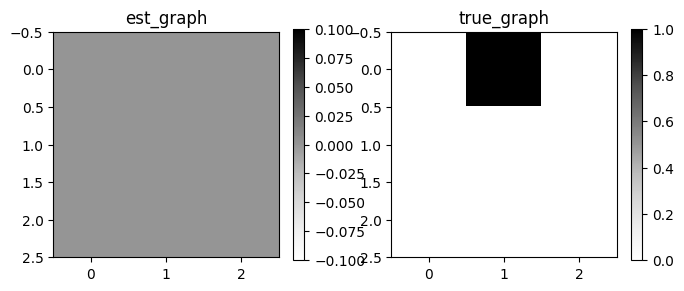

The problem has 91 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 4277
Generating moment matrix...
Current number of SDP variables: 95 (done: 2.24%, ETA 00:00:5.8)

/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: divide by zero encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Reduced number of SDP variables: 4277
Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reduced number of SDP variables: 4277
Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: divide by zero encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/

Reduced number of SDP variables: 4277
Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes      

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Estimated number of SDP variables: 4277
Generating moment matrix...
Reduced number of SDP variables: 4277
Processing 120/120 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 4277            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 22578)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Li

/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:593: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x)) / np.std(x)
/usr/local/lib/python3.10/dist-packages/castle/common/independence_tests.py:594: RuntimeWarning: invalid value encountered in divide
  y = (y - np.mean(y)) / np.std(y)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


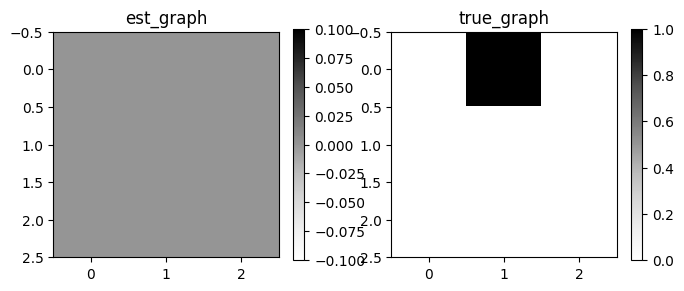

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0} {'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/usr/local/lib/python3.10/dist-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


In [ ]:
import time
import sys
import os
import re
import math
import torch
import numpy as np
import pandas as pd
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Datasets/Synthetic datasets/Generate_SyntheticData/"
read_Dir=os.listdir(File_PATH)[0]
print(read_Dir)
file_name =re.split("\.", read_Dir)[0]
file = os.path.join(File_PATH, file_name)
data_load = np.load(file+'.npz')
Raw_data = data_load['x']
true_dag = data_load['y']
data1 = Raw_data[:, :5, :5]
anmNCPO1 = ANM_NCPO(alpha=0.05)
anmNCPO1.learn(data = data1)
GraphDAG(anmNCPO1.causal_matrix, true_dag, show=True)
met1 = MetricsDAG(anmNCPO1.causal_matrix, true_dag)
data2 = Raw_data[:, :6, :5]
anmNCPO2 = ANM_NCPO(alpha=0.05)
anmNCPO2.learn(data = data2)
GraphDAG(anmNCPO2.causal_matrix, true_dag, show=True)
met2 = MetricsDAG(anmNCPO2.causal_matrix, true_dag)

df = pd.DataFrame(columns=['Datasize', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
print(met1.metrics,met2.metrics)

In [ ]:
df = pd.DataFrame(columns=['Datasize', 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
print(met1.metrics,met2.metrics)

# df = pd.concat([df, met1.metrics])
dict1 = {'Datasize':5}
dict2 = met1.metrics
dict = {**dict1, **dict2}

df1 = pd.concat([df,pd.DataFrame([dict])])
print(df1)

df2 = pd.concat([pd.DataFrame([{** {'Datasize':6}, **met1.metrics},dict])])
print(df2)


#print(mm)
# df = pd.concat([df, df1])

df2.to_csv('Scores_pc_variant_parallel.csv')

{'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0} {'fdr': 0.0, 'tpr': 0.0, 'fpr': 0.0, 'shd': 1, 'nnz': 0, 'precision': nan, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}
  Datasize  fdr  tpr  fpr shd nnz  precision  recall  F1  gscore
0        5  0.0  0.0  0.0   1   0        NaN     0.0 NaN     0.0
   Datasize  fdr  tpr  fpr  shd  nnz  precision  recall  F1  gscore
0         6  0.0  0.0  0.0    1    0        NaN     0.0 NaN     0.0
1         5  0.0  0.0  0.0    1    0        NaN     0.0 NaN     0.0


##__Read data__




In [ ]:
import numpy as np
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    print(Raw_data.shape, true_dag.shape)


(16, 120, 500) (16, 16)


##__Test__

In [ ]:
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.learn(data = Rawdata)
anmNCPO.causal_matrix

In [ ]:
import sys
import warnings


def test_my_function(alpha, data):
    warnings.filterwarnings("ignore")
    # 保存原始stdout
    original_stdout = sys.stdout
    # 重定向stdout到/dev/null或nul
    sys.stdout = open('/dev/null', 'w')  # Unix
    # sys.stdout = open('nul', 'w')  # Windows

    # 执行测试
    anmNCPO = ANM_NCPO(alpha=alpha)
    print(data.shape)
    anmNCPO.learn(data = data)
    return anmNCPO.causal_matrix

    # 恢复stdout
    sys.stdout = original_stdout

causal_matrix = test_my_function(alpha=0.05, data = Rawdata)

#met = MetricsDAG(causal_matrix, true_dag)

KeyboardInterrupt: 

##__GraphDAG__
* Plot GraphDAG heatmap of causal_matrix and true_dag


In [ ]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
GraphDAG(causal_matrix, true_dag, show=True, save_name = 'Krebs_cycle.png')

##__Cal F1 score__
# Calculate 'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'

In [ ]:
met = MetricsDAG(causal_matrix, true_dag)
met.metrics

In [ ]:
import numpy as np
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'Krebs_Cycle_16_43_TS'
    # file_name = 'LinearGauss_6_15_TS'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    DataSize = range(10,60,5)
    df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])
    for i in DataSize:
        data = Raw_data['x'][:i]
        anmNCPO = ANM_NCPO(alpha=0.05)
        anmNCPO.learn(data=data)
        print('datasize=' + str(i-1) + ' is done!')
        df = pd.concat([df, pd.DataFrame([met.metrics])])
    df1=df.assign(DataSize = DataSize)
    df1.to_csv('summary_' +file_name+'.csv', index=False)
    print(df1)
    # print(Raw_data.shape, true_dag.shape)

## Heatmap for testing synthetic data

In [ ]:
class Ancpop_Real(object):
    '''
    A class for simulating random (causal) DAG, where any DAG generator
    self.method would return the weighed/binary adjacency matrix of a DAG.

    Parameters
    ----------
    File_PATH: str
        Save file path
    File_NAME: str
        Read data name
    start: int
        Start number of samples for standard trainning dataset
    stop: int
        stop number of samples for standard trainning dataset
    step: int
        step number of samples for standard trainning dataset

    '''
    def __init__(self, File_PATH,File_NAME, start, stop, step):
        self.File_PATH = File_PATH
        self.File_NAME = File_NAME
        self.start = start
        self.stop = stop
        self.step = step
        self.datasize = range(self.start, self.stop, self.step)
        self.datasize_num = len(self.datasize)
        self.data_name = re.split("\.", self.File_NAME)[0]

    def Ancpop_real_Test(self):
        ################################################  Test Data #############################################
        self.File_PATH_Heatmaps = self.File_PATH + 'Results_'+self.data_name+ '/'
        self.Table_PATH_Summary = self.File_PATH_Heatmaps + 'Summary_'+self.data_name+'.csv'
        if not os.path.exists(self.Table_PATH_Summary):
            print('INFO: Testing '+ self.data_name+'!')
            self.File_PATH_Base = self.File_PATH + 'Details_'+self.data_name+ '/'
            self.Ancpop_real_estimate(self)
        else:
            print('INFO: Finished '+ self.data_name+'Sampling!')

        ################################################  Create And Plot #############################################
        #self.Plots_ANCPOP_Real(self)
        print('INFO: Finished plotting '+ self.data_name + '!')

    @staticmethod
    def Ancpop_real_estimate(self):
        read_Dir=os.listdir(self.File_PATH)
        if len(read_Dir) == 1:
            self.File_TYPE = re.split("\.", self.File_NAME)[1]
            if self.File_TYPE =='npz':
                print(self.File_TYPE)
                Tests_data = np.load(self.File_PATH+self.File_NAME, allow_pickle=True)
                Raw_data = Tests_data['x']
                true_dag = Tests_data['y']
                #print(Tests_data['x'][:20], Raw_data[:20],true_dag)
                #self.nodes_num = len(causal_matrix)
                #self.edges_num = len(causal_matrix[causal_matrix == 1])
            elif self.File_TYPE =='tar':
                Tests_data = np.load(self.File_NAME+'.tar', allow_pickle=True)
            else:
                print('INFO: Cannot Read '+self.File_TYPE+' Data!')
        else:
            Raw_data_path = self.File_PATH+read_Dir[0]
            Raw_data = pd.read_csv(Raw_data_path, header=0, index_col=0)
            DAG_data_path = self.File_PATH+read_Dir[1]
            DAG_data = pd.read_csv(DAG_data_path, header=0, index_col=0)


        ############################################## Create Files ###################################
        if not os.path.exists(self.File_PATH_Base):
            os.makedirs(self.File_PATH_Base)
        self.File_PATH_MetricsDAG = self.File_PATH_Base +'MetricsDAG/'
        if not os.path.exists(self.File_PATH_MetricsDAG):
            os.makedirs(self.File_PATH_MetricsDAG)
        if not os.path.exists(self.File_PATH_Heatmaps):
            os.makedirs(self.File_PATH_Heatmaps)

        duration_anm_ncpop = []
        f1_anm_ncpop = []
        df = pd.DataFrame(columns=['fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore'])

        #df = pd.DataFrame(columns=['DataSize','False_Discovery_Rate', 'True_Positive_Rate', 'False_Positive_Rate', 'SHD', 'NNZ', 'Precision', 'Recall', 'F1_Score', 'G_score'])
        for i in self.datasize:
            data = Raw_data[:i]
            t_start = time.time()
            anmNCPO = ANM_NCPO(alpha=0.05)
            anmNCPO.learn(data = data)
            # plot predict_dag and true_dag
            GraphDAG(anmNCPO.causal_matrix, true_dag, show=False, save_name = self.File_PATH_MetricsDAG+self.data_name+'_' + str(i) + 'Datasize.png')
            met = MetricsDAG(anmNCPO.causal_matrix, true_dag)
            #f1_result.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.data_name+'.csv',index=False)
            if math.isnan(float(met.metrics['F1'])):
              f1_anm_ncpop.append(0.2)
            else:
              print(math.isnan(met.metrics['F1']),met.metrics['F1']==np.nan)
              f1_anm_ncpop.append(met.metrics['F1'])
            duration_anm_ncpop.append(time.time()-t_start)
            print(self.data_name+'_' + str(i) + 'Datasize is done!'+'F1 Score is'+ str(met.metrics['F1'])+'.')
            #'Time Duration is'+ str(time.time()-t_start))
            df = pd.concat([df, pd.DataFrame([met.metrics])])
        df.to_csv(self.Table_PATH_Summary, index=False)
        #df = pd.concat({"DataSize":[self.datasize]},{df.loc[:, ['F1']]})
        df_F1 = pd.DataFrame({"DataSize":self.datasize,'F1_Score':f1_anm_ncpop,'Duration':duration_anm_ncpop})
        #f1_result = df.loc[:, ['DataSize','F1_Score']]
        df_F1.to_csv(self.File_PATH_Heatmaps + 'F1_'+self.data_name+'.csv',index=False)
        return df_F1

    '''
    @staticmethod
    def Summary_Results(self):
        f1_anm_ncpop = pd.DataFrame()
        tqdm=os.listdir(self.File_PATH_Details)
        for i in range(0,len(tqdm)):
            File_PATH = os.path.join(self.File_PATH_Details,tqdm[i])
            #ds = re.split("D",re.split("edges_",re.split("nodes_", re.split("\.", tqdm[i])[0])[1])[1])[0]
            df = pd.read_csv(File_PATH)
            f1_anm_ncpop_nan = df.loc[:,'F1']
            if len([f1_anm_ncpop_nan == 0]) == len(f1_anm_ncpop_nan):
              f1_anm_ncpop_mean = 0.2
            else:
              f1_anm_ncpop_mean = round(np.nanmean(f1_anm_ncpop_nan), 3)
            f1_anm_ncpop = pd.concat((f1_anm_ncpop, pd.DataFrame([ds, f1_anm_ncpop_mean])), axis=1)
        f1_result = pd.DataFrame(np.array(f1_anm_ncpop.T), columns=['Linear','Gauss','Nodes','Edges','DataSize','F1_Score'])
        f1_result.to_csv(self.Table_PATH_Summary,index=False)
        return f1_result'''

    @staticmethod
    def Plots_ANCPOP_Real(self):
        self.pro_rang = np.arange(self.start, self.stop, self.step)
        self.obs_rang = np.arange(self.start, self.stop, self.step)
        fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,20))
        z =[]
        zz = pd.read_csv(self.File_PATH_Heatmaps + 'F1_'+self.data_name+'.csv', header=[1], index_col=0)
        z = zz.to_numpy()
        z_min=np.min(z)
        z_max=np.max(z)
        c = axes.imshow(z, cmap =plt.cm.bone_r, vmin = z_min, vmax = z_max,
                        interpolation ='nearest', origin ='upper')
        axes.set_xlabel('length of time windows '+r'$T$',fontsize=10)
        #axes.set_ylabel('F1 score ',fontsize=10)
        positions = range(9)
        labels=self.datasize
        axes.yaxis.set_major_locator(ticker.FixedLocator(positions))
        axes.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
        for ytick in axes.get_yticklabels():
            ytick.set_fontsize(4)
        axes.xaxis.set_major_locator(ticker.FixedLocator(positions))
        axes.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
        for xtick in axes.get_xticklabels():
            xtick.set_fontsize(4)

        fig.colorbar(c, ax=axes.ravel().tolist())
        plt.savefig(self.File_PATH_Heatmaps +'Heatmap_ '+self.data_name+'.pdf', bbox_inches='tight')


## ANM-NCPOP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from itertools import combinations
from castle.common import BaseLearner, Tensor
from castle.common.independence_tests import hsic_test
# from inputlds import*
# from functions import*
from ncpol2sdpa import*
from math import sqrt


class NCPOLR(object):
    """Estimator based on NCPOP Regressor

    References
    ----------
    Quan Zhou https://github.com/Quan-Zhou/Proper-Learning-of-LDS/blob/master/ncpop/functions.py

    Examples
    --------
    """

    def __init__(self, **kwargs):
        super(NCPOLR, self).__init__()

    def estimate(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        X : array
            Variable seen as cause
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """

        T = len(Y)
        level = 1

        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)
        n = generate_operators("m", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.00005*sum(p[i] for i in range(T))

        # Constraints
        ine1 = [f[i] - G*X[i] - n[i] for i in range(T)]
        ine2 = [-f[i] + G*X[i] + n[i] for i in range(T)]
        ine3 = [p[i]-n[i] for i in range(T)]
        ine4 = [p[i]+n[i] for i in range(T)]
        ines = ine1+ine2+ine3+ine4

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,f,n,p]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')
        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[n[i]])
            print(est_noise)
            return est_noise
        else:
            print('Cannot find feasible solution.')
            return

    def estimate2(self, X, Y):
        """Fit Estimator based on NCPOP Regressor model and predict y or produce residuals.
        The module converts a noncommutative optimization problem provided in SymPy
        format to an SDPA semidefinite programming problem.

        Parameters
        ----------
        Y: array
            Variable seen as effect

        Returns
        -------
        y_predict: array
            regression predict values of y or residuals
        """
        Y = np.transpose(Y)
        T = len(Y)-1
        level = 1


        # Decision Variables
        G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
        Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
        # m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
        q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
        p = generate_operators("p", n_vars=T, hermitian=True, commutative=False)
        f = generate_operators("f", n_vars=T, hermitian=True, commutative=False)

        # Objective
        obj = sum((Y[i]-f[i])**2 for i in range(T)) + 0.0005*sum(p[i]**2 for i in range(T)) + 0.001*sum(q[i]**2 for i in range(T))

        #c1*sum(p[i]**2 for i in range(T)) + c2*sum(q[i]**2 for i in range(T))

        # Constraints
        ine1 = [f[i] - Fdash*X[i+1] - p[i] for i in range(T)]
        ine2 = [-f[i] + Fdash*X[i+1] + p[i] for i in range(T)]
        ine3 = [X[i+1] - G*X[i] - q[i] for i in range(T)]
        ine4 = [-X[i+1] + G*X[i] + q[i] for i in range(T)]
        #ine5 = [(Y[i]-f[i])**2 for i in range(T)]
        ines = ine1+ine2+ine3+ine4 #+ine5

        # Solve the NCPO
        sdp = SdpRelaxation(variables = flatten([G,Fdash,f,p,q]),verbose = 1)
        sdp.get_relaxation(level, objective=obj, inequalities=ines)
        sdp.solve(solver='mosek')

        #sdp.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:/Users/zhouq/Documents/sdpa7-windows/sdpa.exe"})
        print(sdp.primal, sdp.dual, sdp.status)

        if(sdp.status != 'infeasible'):
            print('ok.')
            est_noise = []
            for i in range(T):
                est_noise.append(sdp[p[i]])
            print(est_noise)
            return est_noise, X[1:]
        else:
            print('Cannot find feasible solution.')
            return


In [ ]:
class ANM_NCPO(BaseLearner):
    """
    Nonlinear causal discovery with additive noise models

    Use Estimator based on NCPOP Regressor and independent Gaussian noise,
    For the independence test, we implemented the HSIC with a Gaussian kernel,
    where we used the gamma distribution as an approximation for the
    distribution of the HSIC under the null hypothesis of independence
    in order to calculate the p-value of the test result.

    References
    ----------
    Hoyer, Patrik O and Janzing, Dominik and Mooij, Joris M and Peters,
    Jonas and Schölkopf, Bernhard,
    "Nonlinear causal discovery with additive noise models", NIPS 2009

    Parameters
    ----------
    alpha : float, default 0.05
        significance level be used to compute threshold

    Attributes
    ----------
    causal_matrix : array like shape of (n_features, n_features)
        Learned causal structure matrix.

    Examples
    --------
    """

    def __init__(self, alpha=0.05):
        super(ANM_NCPO, self).__init__()
        self.alpha = alpha

    def learn(self, data, columns=None, regressor=NCPOLR(),test_method=hsic_test, **kwargs):
        """Set up and run the ANM_NCPOP algorithm.

        Parameters
        ----------
        data: numpy.ndarray or Tensor
            Training data.
        columns : Index or array-like
            Column labels to use for resulting tensor. Will default to
            RangeIndex (0, 1, 2, ..., n) if no column labels are provided.
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOLR.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        """

        self.regressor = regressor

        # create learning model and ground truth model
        data = Tensor(data, columns=columns)

        node_num = data.shape[0]
        self.causal_matrix = Tensor(np.zeros((node_num, node_num)))

        for i, j in combinations(range(node_num), 2):
            x = data[i, :, :]
            y = data[j, :, :]
            xx = x.reshape(-1,1)
            yy = y.reshape(-1,1)

            flag = test_method(xx, yy, alpha=self.alpha)
            if flag == 1:
                continue
            # test x-->y
            flag = self.ANMNCPO_fitness(x, y, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[i, j] = 1
            # test y-->x
            flag = self.ANMNCPO_fitness(y, x, regressor = regressor, test_method=test_method)
            if flag:
                self.causal_matrix[j, i] = 1

    def ANMNCPO_fitness(self, x, y, regressor=NCPOLR(), test_method=hsic_test):
        """Compute the fitness score of the ANM_NCPOP Regression model in the x->y direction.

        Parameters
        ----------
        x: array
            Variable seen as cause
        y: array
            Variable seen as effect
        regressor: Class
            Nonlinear regression estimator, if not provided, it is NCPOP.
            If user defined, must implement `estimate` self.method. such as :
                `regressor.estimate(x, y)`
        test_method: callable, default test_method
            independence test self.method, if not provided, it is HSIC.
            If user defined, must accept three arguments--x, y and keyword
            argument--alpha. such as :
                `test_method(x, y, alpha=0.05)`
        Returns
        -------
        out: int, 0 or 1
            If 1, residuals n is independent of x, then accept x --> y
            If 0, residuals n is not independent of x, then reject x --> y

        """

        x = scale(x).reshape(-1)
        y = scale(y).reshape(-1)

        ncpop_res = regressor.estimate2(x, y)
        print(x)
        print(y)

        flag = test_method(np.asarray(ncpop_res[0]).reshape((-1, 1)), np.asarray(ncpop_res[1]).reshape((-1, 1)), alpha=self.alpha)

        print(flag)

        return flag



In [ ]:
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################

    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks-data/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
    file_name = 'LinearGauss_6_15'
    data = np.load(File_PATH+file_name+'.npz')
    Raw_data = data['x']
    true_dag = data['y']
    # print(Raw_data.shape, true_dag.shape)
    X = Raw_data[:10,]

In [ ]:
x = X[:,0]
y = X[:,1]
anmNCPO = ANM_NCPO(alpha=0.05)
anmNCPO.ANMNCPO_fitness(x, y, regressor = NCPOLR(), test_method=hsic_test)

[ 0.86653643  0.69823488 -0.51156086  0.10436835 -1.45729735  1.27956373
 -0.9025051   2.20115662 -3.57053799  0.78085863]
[ 1.92383191  0.99109127  0.3806108  -0.74776636 -1.3176775   1.33291008
 -0.68454025  1.25598233  0.49672635  0.3292758 ]
The problem has 31 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 527
Generating moment matrix...
Reduced number of SDP variables: 527
Processing 10/40 constraints...

Processing 40/40 constraints...
Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 527             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 0               
  Matrix variables       : 1 (scalarized: 2628)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - d

1